In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
from pathlib import Path


In [13]:
IMAGE_SIZE = (30, 30)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 15
TRAIN_DIR = './DataSet/train'
VALIDATION_DIR = './DataSet/valid'
TEST_DIR = './DataSet/test'
CLASSES = [
    'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
    'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40',
    'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80',
    'Speed Limit 90', 'Stop'
]


In [3]:
def load_darknet_data(image_dir, label_dir, image_size, num_classes, augment=False):
    images = []
    labels = []
    for image_path in Path(image_dir).glob("*.jpg"):
        label_path = label_dir / (image_path.stem + ".txt")

        original_img = Image.open(image_path)
        width, height = original_img.size

        if label_path.exists():
            with open(label_path, "r") as f:
                line = f.readline()
                format_line = line.strip().split()

                if len(format_line) < 5:
                    print("Problem in file: " + str(label_path))
                    continue

                class_id = int(format_line[0])
                x_center = float(format_line[1])
                y_center = float(format_line[2])
                bbox_width = float(format_line[3])
                bbox_height = float(format_line[4])

                x_center_pixel = int(x_center * width)
                y_center_pixel = int(y_center * height)
                bbox_width_pixel = int(bbox_width * width)
                bbox_height_pixel = int(bbox_height * height)

                # Calculate crop box
                left = max(0, x_center_pixel - bbox_width_pixel // 2)
                top = max(0, y_center_pixel - bbox_height_pixel // 2)
                right = min(width, x_center_pixel + bbox_width_pixel // 2)
                bottom = min(height, y_center_pixel + bbox_height_pixel // 2)

                cropped_img = original_img.crop((left, top, right, bottom))
                cropped_img = cropped_img.resize(image_size)

                img = tf.keras.utils.img_to_array(cropped_img) / 255.0
                label = to_categorical(class_id, num_classes)

                if augment:
                    # Apply random transformations for augmentation
                    augmented_images, augmented_labels = apply_augmentation(img, label)
                    images.extend(augmented_images)
                    labels.extend(augmented_labels)
                else:
                    images.append(img)
                    labels.append(label)
        else:
            raise FileNotFoundError(f"Label file not found for {image_path}")

    return np.array(images), np.array(labels)

def apply_augmentation(image, label):
    aug_images = []
    aug_labels = []
    data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image = np.expand_dims(image, axis=0)  # Add batch dimension
    for _ in range(5):  # Generate 5 augmented images
        augmented = next(data_gen.flow(image, batch_size=1))
        aug_images.append(augmented[0])
        aug_labels.append(label)

    return aug_images, aug_labels

In [7]:
TRAIN_IMAGE_DIR = Path(TRAIN_DIR) / "images"
TRAIN_LABEL_DIR = Path(TRAIN_DIR) / "labels"
VALID_IMAGE_DIR = Path(VALIDATION_DIR) / "images"
VALID_LABEL_DIR = Path(VALIDATION_DIR) / "labels"

# Load datasets
train_images, train_labels = load_darknet_data(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, IMAGE_SIZE, NUM_CLASSES, augment=True)
valid_images, valid_labels = load_darknet_data(VALID_IMAGE_DIR, VALID_LABEL_DIR, IMAGE_SIZE, NUM_CLASSES)


Problem in file: DataSet\train\labels\FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.txt
Problem in file: DataSet\train\labels\FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.txt
Problem in file: DataSet\train\labels\FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt


In [8]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,207 (1.27 MB)

 Trainable params: 332,015 (1.27 MB)

 Non-trainable params: 192 (768.00 B)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', mode='auto',verbose=1)
history = model.fit(
    train_dataset,
    epochs=5,
    batch_size=BATCH_SIZE,
    validation_data=valid_dataset,
    callbacks=[reduce_lr]
)

Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.8493 - loss: 0.4585 - val_accuracy: 0.9376 - val_loss: 0.2135 - learning_rate: 0.0010
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8673 - loss: 0.4058 - val_accuracy: 0.9263 - val_loss: 0.2387 - learning_rate: 0.0010
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.8826 - loss: 0.3629 - val_accuracy: 0.9376 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.8959 - loss: 0.3132 - val_accuracy: 0.9413 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 5/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9039 - loss: 0.2908 - val_accuracy: 0.9538 - val_loss: 0.1608 - learning_rate: 0.0010


In [27]:
TEST_IMAGE_DIR = Path(TEST_DIR) / "images"
TEST_LABEL_DIR = Path(TEST_DIR) / "labels"

test_images, test_labels = load_darknet_data(TEST_IMAGE_DIR, TEST_LABEL_DIR, IMAGE_SIZE, NUM_CLASSES)

# Convert to TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

# Predict
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_classes, predicted_classes)
print(confusion_mtx)

Problem in file: DataSet\test\labels\FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.txt
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
tf.Tensor(
[[68  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 51  0  0  0  1  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  1  0  1  0  0  1  0  0]
 [ 0  0  0  1 16  1  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  1  0 34  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  1 41  0  0  0  0  1  0  0  0]
 [ 1  0  0  1  0  0  0 47  1  2  2  0  2  0  0]
 [ 0  0  0  0  0  0  0  0 46  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 40  4  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  0 41  0  1  0  0]
 [ 2  0  0  0  0  0  1  0  0  0  1 42  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 55  0  0]
 [ 1  0  2  0  0  0  0  0  0  1  0  0  0 26  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0 46]], shape=(15, 15), dtype=int32)


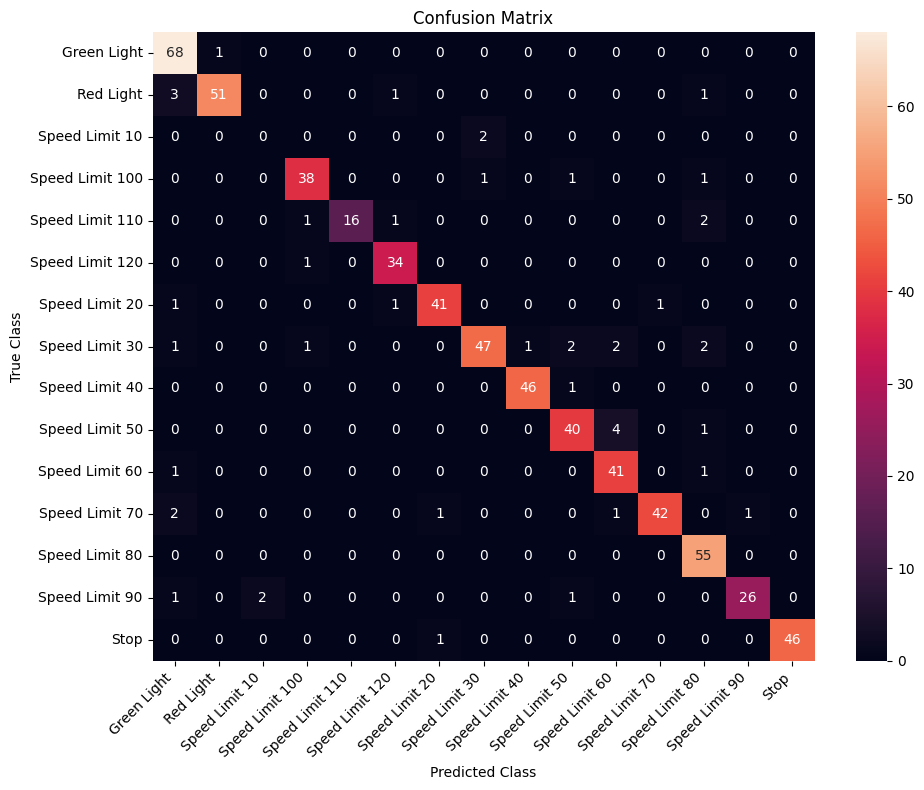

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming CLASSES is the list of class names
CLASS_NAMES = CLASSES

# Compute confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_classes, predicted_classes).numpy()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='rocket', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)              # Keep y-axis labels horizontal
plt.tight_layout()
plt.show()

In [29]:
# Sauvegarde du modèle
model.save('traffic_signs.keras')


In [36]:
from tensorflow.keras.utils import load_img, img_to_array
def classify_single_image(image_path, model, class_names, image_size):
    img = load_img(image_path)
    original_width, original_height = img.size

    img = img.resize((image_size[0], image_size[1]), Image.ANTIALIAS)

    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_class_idx]

    print(f"Predicted Class: {predicted_class} (Confidence: {predictions[0][predicted_class_idx]:.2f})")
    return predicted_class

image_path = "./redlight.png"
predicted_class = classify_single_image(image_path, model, CLASSES, IMAGE_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: Red Light (Confidence: 1.00)
